# Library

In [39]:
import pandas as pd
import numpy as np

#process intent
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder

import random
import re

#data and layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.data import Dataset
import keras
from keras.models import Sequential
from keras import layers, Model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten, Dropout, Conv2DTranspose, LSTM, Bidirectional, Embedding, Reshape
from keras.layers import Concatenate, LeakyReLU, Dense, Input, add, ZeroPadding2D
from keras.optimizers import Adam

#evaluation
from keras.callbacks import TensorBoard
from tqdm import tqdm #progess bar
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

# Data

### Preprocesssing fashion mnist dataset

In [4]:
# Spilt and scale fashion mnist
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train / 255.
X_test = X_test/ 255.

print("-------------------------------------------------")
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

-------------------------------------------------


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# X_train[0]

### Preprocessing Intent dataset for fashion mnist dataset

#### Import Intent dataset

In [5]:
import os
print(os.getcwd())


H:\TestCereBro


In [6]:
# https://github.com/hungnq1310/hero131a/Intent.csv
import pandas as pd

file_path = os.path.join(os.getcwd(), "Intent.csv")

data= pd.read_csv(file_path, header = None)
data[0:10]

,0
0,where I can find the T-shirt/top shop;T-shirt/top
1,How were the trousers made?;Trouser
2,I would like to find a list of cool things suc...
3,the main uses of these bags?;Bag
4,the name of the dress that a person wears to ...
5,What are the most popular sneakers in the worl...
6,the status on my shirt waranty;Shirt
7,Let's being fashion with the dress in the next...
8,Make the perfect Shirt for a Special Occasion;...
9,The best Pullover Tips That'll Keep You Warm o...


In [7]:
# Fail format so I start to process the column 0
data[0]=data[0].str.split(";")
data[0][1][1].strip()

'Trouser'

In [8]:
# Clean the database
data['intent'] = [data[0][i][1].strip() for i in range(0,len(data))]
data['query'] = [data[0][i][0] for i in range(0,len(data))]
data = data[['intent','query']]
data[0:10]

,intent,query
0,T-shirt/top,where I can find the T-shirt/top shop
1,Trouser,How were the trousers made?
2,Shirt,I would like to find a list of cool things suc...
3,Bag,the main uses of these bags?
4,Dress,the name of the dress that a person wears to ...
5,Sneaker,What are the most popular sneakers in the world?
6,Shirt,the status on my shirt waranty
7,Dress,Let's being fashion with the dress in the next...
8,Shirt,Make the perfect Shirt for a Special Occasion
9,Pullover,The best Pullover Tips That'll Keep You Warm o...


#### Preprocessing intent 

In [9]:
# Convert to list
entire_sents = list(data["query"])
entire_intents = list(data["intent"])

# Prepare Labels and for every sample, assign an unique category id to each intent in a new column in dataframe.

# This method is useful for obtaining a numeric representation of an array
data['category_id'] = data['intent'].factorize()[0] 
### create new columns               ### Like enumarate function

# create new table contains intent and category_id
category_id_df = data[['intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,intent,category_id
0,T-shirt/top,0
1,Trouser,1
2,Shirt,2
3,Bag,3
4,Dress,4
5,Sneaker,5
9,Pullover,6
10,ankle-boot,7
33,Coat,8
40,Sandal,9


In [10]:
# Figure some nescessary part for later uses.
category_to_id = dict(category_id_df.values) # return dict
id_to_category = dict(category_id_df[['category_id', 'intent']].values) # return dict
id_to_category

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Shirt',
 3: 'Bag',
 4: 'Dress',
 5: 'Sneaker',
 6: 'Pullover',
 7: 'ankle-boot',
 8: 'Coat',
 9: 'Sandal'}

#### Data cleaning

In [11]:
def cleaning(sents):
    words = []
    lemmatizer = WordNetLemmatizer() # return the basic form of words
    for sent in sents:
        # Remove anything that is not alphanumeric character
        cleaned_sent = re.sub(r'[^ a-z A-Z 0-9]', " ", sent)

        # Split sentence into chunks of words i.e. tokens
        word = nltk.tokenize.word_tokenize(cleaned_sent)
        
        # Lemmatize the tokens i.e. convert it to its dictionary form
        words.append([lemmatizer.lemmatize(w.lower()) for w in word])
        
    return words

In [12]:
# # The library of colab doesn't contain these libraries so I manually download it
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
# get the clean sentences of function cleaning
cleaned_entire_sents = cleaning(entire_sents)
for i in range(0,10):
  print(cleaned_entire_sents[i])

['where', 'i', 'can', 'find', 'the', 't', 'shirt', 'top', 'shop']
['how', 'were', 'the', 'trouser', 'made']
['i', 'would', 'like', 'to', 'find', 'a', 'list', 'of', 'cool', 'thing', 'such', 'a', 'nice', 'shirt']
['the', 'main', 'us', 'of', 'these', 'bag']
['the', 'name', 'of', 'the', 'dress', 'that', 'a', 'person', 'wear', 'to', 'work']
['what', 'are', 'the', 'most', 'popular', 'sneaker', 'in', 'the', 'world']
['the', 'status', 'on', 'my', 'shirt', 'waranty']
['let', 's', 'being', 'fashion', 'with', 'the', 'dress', 'in', 'the', 'next', '5', 'minute']
['make', 'the', 'perfect', 'shirt', 'for', 'a', 'special', 'occasion']
['the', 'best', 'pullover', 'tip', 'that', 'll', 'keep', 'you', 'warm', 'on', 'a', 'cold', 'winter', 'day']


#### Encode the intent input

In [14]:
def create_tokenizer(words, filters = '!"#$%&()}~\t\n'): 
  token = Tokenizer(filters = filters) # create token with specified filter
  token.fit_on_texts(words)
  return token

def max_length(words):
  return(len(max(words, key = len))) # return the longest sentences which have in dataset

def encoding_doc(token, words): # convert each word of sentence to specificed number, like Label_Encoder
  return(token.texts_to_sequences(words))

def padding_doc(encoded_doc, max_length): # pad 0 to sentence so each sentence of data have the same length
  return(keras.utils.pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))


In [15]:
word_tokenizer = create_tokenizer(cleaned_entire_sents) 
vocab_size = len(word_tokenizer.word_index) + 1 # number of vocabulary of token
# print(word_tokenizer.word_index)
max_length = max_length(cleaned_entire_sents)
print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 623 and Maximum length = 23


In [16]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_entire_sents) # encode the sentences
# print(encoded_doc)

padded_doc = padding_doc(encoded_doc, max_length) # pad [0] to the length of MAX_LENGTH 
print("Shape of padded docs = ",padded_doc.shape)

output_tokenizer = create_tokenizer(list(category_id_df['intent'])) # encode the intents
output_tokenizer.word_index

Shape of padded docs =  (449, 23)


{'t-shirt/top': 1,
 'trouser': 2,
 'shirt': 3,
 'bag': 4,
 'dress': 5,
 'sneaker': 6,
 'pullover': 7,
 'ankle-boot': 8,
 'coat': 9,
 'sandal': 10}

In [17]:
encoded_output = encoding_doc(output_tokenizer, entire_intents) # convert intent to coresponding number in tokenizer
# print(encoded_output)
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
print(encoded_output.shape)

(449, 1)


In [18]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False) # Like label_encoder
  return(o.fit_transform(encode))

output_one_hot = one_hot(encoded_output)
output_one_hot.shape # shape 10 is the max_length

(449, 10)

# Model

### Classify intent of input

In [19]:
# Rows 0 to 2400 corresponds to Training data
X_train_enconded = padded_doc[:350]
y_train_encoded = output_one_hot[:350]

# Rows 2400 to 3000 corresponds to Testing data
X_test_encoded = padded_doc[350:]
y_test_encoded = output_one_hot[350:]

In [20]:
def create_model_predict_intent(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False)) # turns positive integers (indexes) into dense vectors of fixed size.
  model.add(Bidirectional(LSTM(128))) # apply LSTM layer before Bidirectional Layer
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = "softmax"))
  
  return model

In [21]:
model_cnn_predict_intent = create_model_predict_intent(vocab_size, max_length)

model_cnn_predict_intent.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_cnn_predict_intent.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 128)           79744     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 351,466
Trainable params: 271,722
Non-trainable params: 79,744
_____________________________________________

In [22]:
tensorboard_classify = TensorBoard(log_dir = "./Question4/logs/Model_cnn_intent_classifier/".format(time()))

# Give the tensorboard and train my CNN model
model_cnn_predict_intent.fit(X_train_enconded, y_train_encoded, epochs = 50, batch_size = 10 , callbacks = [tensorboard_classify])

Epoch 1/50
35/35 [==============================] - 9s 16ms/step - loss: 2.3029 - accuracy: 0.1114
Epoch 2/50
35/35 [==============================] - 0s 12ms/step - loss: 2.2759 - accuracy: 0.1171
Epoch 3/50
35/35 [==============================] - 0s 12ms/step - loss: 2.2488 - accuracy: 0.1657
Epoch 4/50
35/35 [==============================] - 1s 16ms/step - loss: 2.2265 - accuracy: 0.1543
Epoch 5/50
35/35 [==============================] - 1s 15ms/step - loss: 2.1660 - accuracy: 0.1943
Epoch 6/50
35/35 [==============================] - 0s 12ms/step - loss: 2.1210 - accuracy: 0.2171
Epoch 7/50
35/35 [==============================] - 0s 13ms/step - loss: 1.9647 - accuracy: 0.2914
Epoch 8/50
35/35 [==============================] - 0s 14ms/step - loss: 1.8031 - accuracy: 0.3914
Epoch 9/50
35/35 [==============================] - 0s 14ms/step - loss: 1.5924 - accuracy: 0.4143
Epoch 10/50
35/35 [==============================] - 0s 13ms/step - loss: 1.3543 - accuracy: 0.5457
Epoch 11/

In [ ]:
# Saved model

model_cnn_predict_intent.save(os.path.join('Saved Models', 'Question4', 'CNN_predict_model'))

### Cluster dataset model

In [23]:
category_id_df

,intent,category_id
0,T-shirt/top,0
1,Trouser,1
2,Shirt,2
3,Bag,3
4,Dress,4
5,Sneaker,5
9,Pullover,6
10,ankle-boot,7
33,Coat,8
40,Sandal,9


Create a model that cluster the fashion_mnist dataset

##### Using CNN model

In [ ]:
# def create_model_clustering_data():
#     return tf.keras.Sequential([
#             tf.keras.layers.Conv2D(32, (3,3),input_shape=(28,28,1),padding = "same"),
#             tf.keras.layers.Conv2D(64, (3,3),padding = "same"),
#             tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#             tf.keras.layers.Dropout(.25),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(.5),
#             tf.keras.layers.Dense(10, activation = 'softmax')])
    
# model_cnn_clustering = create_model_clustering_intent()
# model_cnn_clustering.summary()

In [ ]:
# model_cnn_clustering.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# tensorboard_cluster = TensorBoard(log_dir = ".Question4/logs/Model_cnn_clustering_intent/".format(time()))

# # extend dim for CNN
# X_train_expand = np.expand_dims(X_train, axis=-1)
# X_test_expand = np.expand_dims(X_test, axis=-1)
# X_train_expand.shape, X_test_expand.shape

# # Training
# model_cnn_clustering.fit(X_train_expand, y_train, epochs=10, batch_size = 60, callbacks = [tensorboard_cluster])

# label_image_predict = model_cnn_clustering.predict(X_test_expand)

# # label_image_predict = len(model_cnn_clustering)
# label_image_predict

In [ ]:
# # Convert label_img_pred to shape(10000,1)
# for n in range(0,len(label_image_predict)):
#   label_image_predict[n] = np.argmax(label_image_predict[n])

# # get the first columns of label_image_predict
# label_hat = label_image_predict[:,1]
# cluster_indexes = get_numof_each_cluster(label_hat)
# cluster_indexes[5][100] # the index of image belong to cluster 5

##### Using K-means

In [24]:
def get_numof_each_cluster(labels):
  num_cluster_labels = len(np.unique(labels)) # 10 labels with corresponding types

  # empty list
  cluster_indexes = [[] for i in range(num_cluster_labels)] 
  #print(cluster_indexes)

  for i,label in enumerate(labels):  # I use the predict X_test to give the cluster of intent in RUNNING part.
      for n in range(num_cluster_labels):
          if label == n:
              cluster_indexes[n].append(i)
          else:
              continue
  for i in range(num_cluster_labels):
    print('No. of items in Cluster ' + str(i) + ': ' + str(len(cluster_indexes[i])))            
  return cluster_indexes

In [25]:
# Flatten datasets
X_train_flat = X_train.reshape(60000, 784)

# I only use one X_train to train k-means model and get the labels but not using the X_test in that model

In [26]:
# Using k-means with pre-specified number of clusters
from sklearn.cluster import KMeans

kmeans = KMeans(init = 'k-means++', n_clusters = 10, n_init = 10, max_iter = 1000)
kmeans.fit(X_train_flat)

KMeans(max_iter=1000, n_clusters=10)

In [27]:
labels = kmeans.labels_
labels.shape

(60000,)

In [28]:
cluster_of_kmean = get_numof_each_cluster(labels)

No. of items in Cluster 0: 7391
No. of items in Cluster 1: 7763
No. of items in Cluster 2: 2569
No. of items in Cluster 3: 9078
No. of items in Cluster 4: 4292
No. of items in Cluster 5: 6572
No. of items in Cluster 6: 7466
No. of items in Cluster 7: 9619
No. of items in Cluster 8: 2347
No. of items in Cluster 9: 2903


### Create extracting feature model like VGG

First time, I use the simple custom model to extract the pattern and using it for replacing the noise of generator because the idea of using image's pattern can highly be convinient for generator. However, the result is bad because the generator completely break the input image without convert it to original image.

In [ ]:
# Expand dims of data for containing no. of feature
X_train_expand = np.expand_dims(X_train, axis = -1)

X_test_expand = np.expand_dims(X_train, axis = -1)

X_train_expand.shape, y_train.shape, X_test_expand.shape, y_test.shape

In [ ]:
# def extract_feature_model():
#     extract_model = Sequential()
#     extract_model.add(Input(shape = (28,28)))
#     extract_model.add(Flatten())
#     extract_model.add(Dense(1024, activation='relu'))
#     extract_model.add(Dense(784))
#     return extract_model


In [ ]:
# # Create model
# extract_model = extract_feature_model()
# extract_model.summary()

Not train anymore because the goal is convert image to something like noise

In [ ]:
# image = X_train[200]

# prd_image = extract_model.predict(image.reshape(1,28,28))  

# plt.imshow(prd_image.reshape(28,28))
# plt.plot()

###### create a custom kernel_intializer

In [ ]:
# Custom the kernel_initializer based on SOBEL filter in edge_detection.
def kernelInitializer(shape, dtype=None): 
    # print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    # print(tf.shape(sobel_x)) (5, 5, 1, 1)
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    # print(tf.shape(sobel_x)) # tf.Tensor([5 5 1 1], shape=(4,), dtype=int32)
    return sobel_x

In [ ]:
# this function will combine edge detection from Sobel filter and random noise. This random noise image will ensure the generator will create image random instead of fixed style

def get_edge_image():
  edge_decect_model = Sequential()
  edge_decect_model.add(Input((28,28,1)))
  edge_decect_model.add(Conv2D(1, kernel_size = (5,5), padding = 'same', kernel_initializer=kernelInitializer, strides = 1, activation='relu'))
  return edge_decect_model


In [ ]:
edge_detect_model = get_edge_image()
edge_detect_model.summary()

### Model GAN

##### get image

In [ ]:
# for each 1000 epoch, I will using sample_images function to temporarily visualizing the ouput image
def sample_images(epoch, extr_model, generator, z_dim = (28, 28, 1), save_output=True):

    r, c = 5, 5

    noise = extr_model.predict(X_train[r*c])
    gen_imgs = generator.predict(noise.reshape((28,28,1)))

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    # get output shape
    output_shape = len(generator.output_shape)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            if output_shape == 3:
                axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            else:
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')

            axs[i, j].axis('off')
            cnt += 1
    plt.show()

    plt.close()

##### Conditional GAN 

In [29]:
def define_discriminator(ip_shape = (28, 28, 1), n_classes = 10):
    ip_label = Input(shape = (1, ))
    li = Embedding(n_classes, 50)(ip_label) # embedding for categorical input(each input described by vector of size 50)
    n_nodes = ip_shape[0] * ip_shape[1]     # 28*28
    li = Dense(n_nodes)(li)                 # (784, 1)
    li = Reshape((ip_shape[0], ip_shape[1], 1))(li)  # Reshape to [28,28,1]
    ip_image = Input(shape = ip_shape)      # ip_image must be the same shape (28, 28, 1)           
    ###
    merge = Concatenate()([ip_image, li])     # (28, 28, 2) with 1 for label and 1 for number filters.
    ###
    layer = Conv2D(128, (3,3), strides = (2,2), padding = 'same')(merge)
    layer = LeakyReLU(alpha = 0.2)(layer)
    layer = Conv2D(128, (3,3), strides = (2,2), padding = 'same')(layer)
    layer = LeakyReLU(alpha = 0.2)(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    out_layer = Dense(1, activation = 'sigmoid')(layer)
    
    dis_model = Model([ip_image, ip_label], out_layer)    # Multiple input 
    opt = Adam(lr = 0.0002, beta_1 = 0.5)
    dis_model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
    return dis_model


In [30]:
def define_generator(latent_dim, n_classes = 10):
    ip_label = Input(shape = (1, ))
    li = Embedding(n_classes, 50)(ip_label) # embedding for categorical input(each input described by vector of size 50)
    n_nodes = 8 * 8                           # specify the latent dim 
    li = Dense(n_nodes)(li)                 # (784, 1)
    li = Reshape((8, 8, 1))(li)             # Reshape to [8, 8, 1]
    ip_latent_space = Input(shape = (latent_dim,))
    
    n_nodes = 128 * 8 *8
    gen = Dense(n_nodes)(ip_latent_space)
    gen = LeakyReLU(alpha = 0.2)(gen)
    gen = Reshape((8, 8, 128))(gen)
    
    merge = Concatenate()([gen, li])
    
    gen = Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'valid')(merge)
    gen = LeakyReLU(alpha = 0.2)(gen)
    gen = Conv2DTranspose(128, (6,6), strides = (1,1), padding = 'valid')(gen)
    gen = LeakyReLU(alpha = 0.2)(gen)
    gen = Conv2DTranspose(128, (6,6), strides = (1,1), padding = 'valid')(gen)
    gen = LeakyReLU(alpha = 0.2)(gen)
    
    out_layer = Conv2D(1, (8,8), activation = 'softmax', padding = 'same')(gen)
    
    gen_model = Model([ip_latent_space, ip_label], out_layer)
    return gen_model


In [31]:
def define_GANS(g_model, d_model):
    d_model.trainable = False
    
    gen_noise , gen_label = g_model.input
    
    gen_output = g_model.output
    
    gan_output = d_model([gen_output, gen_label])
    
    model = Model([gen_noise, gen_label], gan_output)
    
    opt = Adam(lr = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = opt)
    return model

In [32]:
generator = define_generator(100, 10)
discriminator = define_discriminator((28,28,1), 10)
gan_model = define_GANS(generator, discriminator)
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 8192)         827392      ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                            

H:\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
# def generate_real_samples(dataset, n_samples):
#     # split into images and labels
#     images, labels = dataset  
#     # choose random instances
#     ix = randint(0, images.shape[0], n_samples)
#     # select images and labels
#     X, labels = images[ix], labels[ix]
#     # generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
#     y = ones((n_samples, 1))  #Label=1 indicating they are real
#     return [X, labels], y

In [34]:
from numpy.random import randn
from numpy.random import randint

def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [35]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict_on_batch([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))  #Label=0 indicating they are fake
    return [images, labels_input], y


In [41]:
# giving to Dataset of tensorflow
X_train_dataset = Dataset.from_tensor_slices(X_train)
y_train_dataset = Dataset.from_tensor_slices(y_train)
X_test_dataset = Dataset.from_tensor_slices(X_test)
y_test_dataset = Dataset.from_tensor_slices(y_test)

X_train_dataset =  X_train_dataset.batch(60)
y_train_dataset = y_train_dataset.batch(60)
X_test_dataset = X_test_dataset.batch(60)
y_test_dataset = y_test_dataset.batch(60)

In [42]:
def train(g_model, d_model, gan_model, train_data, label_data, latent_dim, n_epochs = 100):
    
    latent_dim = 100
    n_classes = 10
#     y_fake = zeros((n_samples, 1))
    
    for epoch in range(n_epochs):
        
        for batch_image, batch_label in Dataset.zip((train_data, label_data)):   
            j = 0
            y_real = np.ones((len(batch_image), 1))
                             
            d_loss1, _ = d_model.train_on_batch([batch_image, batch_label], y_real)
            
            [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, len(batch_image))
            
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            [z_input, labels_input] = generate_latent_points(latent_dim, len(batch_image))
            
            y_gan = np.ones((len(batch_image), 1))
            
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' % (epoch, j+1, 60000/len(batch_image)), d_loss1, d_loss2, g_loss))
  
    g_model.save('weight_gan.h5')
            

In [43]:
train(generator, discriminator, gan_model, X_train_dataset, y_train_dataset, latent_dim = 100, n_epochs = 10)

Epoch>0, Batch1/16, d1=0.705, d2=0.743 g=0.712
Epoch>0, Batch1/16, d1=0.686, d2=0.664 g=0.791
Epoch>0, Batch1/16, d1=0.708, d2=0.589 g=0.865
Epoch>0, Batch1/16, d1=0.722, d2=0.535 g=0.950
Epoch>0, Batch1/16, d1=0.730, d2=0.481 g=1.020
Epoch>0, Batch1/16, d1=0.734, d2=0.430 g=1.115
Epoch>0, Batch1/16, d1=0.734, d2=0.392 g=1.198
Epoch>0, Batch1/16, d1=0.753, d2=0.346 g=1.316
Epoch>0, Batch1/16, d1=0.755, d2=0.318 g=1.418
Epoch>0, Batch1/16, d1=0.776, d2=0.292 g=1.479
Epoch>0, Batch1/16, d1=0.784, d2=0.268 g=1.538
Epoch>0, Batch1/16, d1=0.739, d2=0.244 g=1.654
Epoch>0, Batch1/16, d1=0.750, d2=0.227 g=1.693
Epoch>0, Batch1/16, d1=0.710, d2=0.211 g=1.779
Epoch>0, Batch1/16, d1=0.713, d2=0.195 g=1.832
Epoch>0, Batch1/16, d1=0.700, d2=0.186 g=1.947
Epoch>0, Batch1/16, d1=0.704, d2=0.165 g=1.974
Epoch>0, Batch1/16, d1=0.663, d2=0.163 g=2.035
Epoch>0, Batch1/16, d1=0.672, d2=0.156 g=2.041
Epoch>0, Batch1/16, d1=0.630, d2=0.152 g=2.118
Epoch>0, Batch1/16, d1=0.634, d2=0.143 g=2.195
Epoch>0, Batc

Epoch>0, Batch1/16, d1=0.001, d2=0.001 g=7.707
Epoch>0, Batch1/16, d1=0.001, d2=0.001 g=8.035
Epoch>0, Batch1/16, d1=0.001, d2=0.001 g=7.715
Epoch>0, Batch1/16, d1=0.000, d2=0.001 g=7.977
Epoch>0, Batch1/16, d1=0.007, d2=0.001 g=7.386
Epoch>0, Batch1/16, d1=0.001, d2=0.001 g=7.399
Epoch>0, Batch1/16, d1=0.000, d2=0.001 g=7.692
Epoch>0, Batch1/16, d1=0.001, d2=0.001 g=7.446
Epoch>0, Batch1/16, d1=0.005, d2=0.001 g=7.381
Epoch>0, Batch1/16, d1=0.000, d2=0.001 g=7.521
Epoch>0, Batch1/16, d1=0.000, d2=0.001 g=7.480
Epoch>0, Batch1/16, d1=0.001, d2=0.001 g=7.443
Epoch>0, Batch1/16, d1=0.000, d2=0.001 g=7.627
Epoch>0, Batch1/16, d1=0.001, d2=0.001 g=7.830
Epoch>0, Batch1/16, d1=0.000, d2=0.001 g=7.722
Epoch>0, Batch1/16, d1=0.000, d2=0.001 g=7.911
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=7.876
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=7.882
Epoch>0, Batch1/16, d1=0.001, d2=0.000 g=7.821
Epoch>0, Batch1/16, d1=0.004, d2=0.001 g=8.009
Epoch>0, Batch1/16, d1=0.000, d2=0.001 g=7.795
Epoch>0, Batc

Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=8.943
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.209
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.359
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.208
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.139
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.370
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.306
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.521
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.177
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.319
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.461
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.338
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.376
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.164
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.414
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.547
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.487
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.508
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.619
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.650
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=9.506
Epoch>0, Batc

Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.196
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.301
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.404
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.293
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.405
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.551
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.192
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.224
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.358
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.372
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.417
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.396
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.563
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.503
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.488
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.570
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.455
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.493
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.609
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.783
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g

Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.016
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.867
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.706
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.710
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.770
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.915
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.859
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.969
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.094
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.007
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.988
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.155
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.883
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.012
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.821
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.137
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.078
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.170
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.315
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.154
Epoch>0, Batch1/16, d1=0.001, d2=0.000 g

Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.279
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.523
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.294
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.251
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.004
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.271
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.073
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.072
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=10.916
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.132
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.436
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.162
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.468
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.275
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.210
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.452
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.362
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.489
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.463
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g=11.746
Epoch>0, Batch1/16, d1=0.000, d2=0.000 g

Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.706
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.006
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.706
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.860
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.905
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.954
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.121
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.921
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.064
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.888
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.089
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.057
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.919
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.118
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.076
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.553
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.177
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.065
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.246
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.111
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g

Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.774
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.998
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.891
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.696
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.903
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.157
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.004
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.829
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.999
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.853
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.109
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.078
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.892
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.006
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.781
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.009
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.900
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.882
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.752
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.069
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g

Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.453
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.207
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.460
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.396
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.318
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.425
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.460
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.431
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.210
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.304
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.467
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.365
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.338
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.577
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.242
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.580
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.524
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.313
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.559
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.628
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g

Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.061
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=10.961
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.232
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.511
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.382
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.435
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.369
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.840
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.876
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.873
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.588
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.623
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.889
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.826
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.509
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=11.778
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.073
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.109
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.175
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.128
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g

Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.699
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.986
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.815
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.803
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.983
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.774
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.881
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.159
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.733
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.861
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.858
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.908
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.946
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.700
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.146
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.904
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.823
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.996
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.200
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.234
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g

Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.079
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.472
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.335
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.170
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=12.907
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.433
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.045
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.088
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.160
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.056
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.733
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.199
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.151
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.170
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.395
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.330
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.446
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.425
Epoch>1, Batch1/16, d1=0.000, d2=0.000 g=13.487
Epoch>1, Batch1/16, d1=0.003, d2=0.000 g=8.882
Epoch>1, Batch1/16, d1=0.000, d2=0.002 g=

Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.046
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.212
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.115
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.277
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=12.985
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.371
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.158
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.090
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.031
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.455
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=12.951
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=12.868
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.265
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.431
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.274
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.225
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.574
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.374
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.281
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.012
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g

Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.780
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.643
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.939
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.041
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.918
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.005
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.997
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.115
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.394
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.683
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.051
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.852
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.696
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.904
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.922
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.803
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.808
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.920
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.877
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.935
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g

Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.231
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.047
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.981
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.207
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.549
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.213
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.339
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.099
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.419
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.186
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.239
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.026
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.143
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.245
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.433
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.909
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.370
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.052
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.154
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.270
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g

Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.395
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.072
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.417
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.943
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.076
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.318
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.652
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.266
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.001
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.521
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.997
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.971
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.304
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.068
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.381
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.448
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.018
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.336
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.197
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.350
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g

Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.985
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=15.003
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.479
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=15.001
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.731
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.596
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.540
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.866
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.878
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.638
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.722
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.711
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.627
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.697
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.610
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.532
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.468
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.705
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.740
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.651
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g

Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.837
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.778
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.715
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.994
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.734
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=15.013
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.942
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=15.098
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.456
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=14.925
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.472
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.202
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=12.988
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.822
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.179
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.563
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.252
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.732
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.196
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g=13.541
Epoch>2, Batch1/16, d1=0.000, d2=0.000 g

Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.818
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.163
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.075
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.095
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.896
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.584
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.590
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.122
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.577
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.163
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.365
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.794
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.118
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.022
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.882
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.881
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.087
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.091
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.186
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=14.830
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g

Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.463
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.331
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.573
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.374
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.803
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.207
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.524
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.326
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.587
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.211
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.568
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.732
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.353
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.551
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.700
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.450
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.411
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.850
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.162
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.847
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g

Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.955
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.092
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.970
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.679
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.937
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.990
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.886
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.870
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.001
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.684
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.041
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.843
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.758
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.725
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.875
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.605
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.978
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.562
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.575
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.027
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g

Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.958
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.686
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.275
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.601
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.483
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.592
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.876
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.759
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.291
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.469
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.579
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.202
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.643
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.971
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.699
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.642
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.602
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.810
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.154
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.576
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g

Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.243
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.618
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.330
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.303
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.360
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.290
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.666
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.474
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.365
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.385
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.979
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.185
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.365
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.629
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.624
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.438
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.448
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.037
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.590
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=16.289
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g

Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.419
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.849
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.504
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.757
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.922
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.667
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.980
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.097
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.670
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.644
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.617
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.504
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.632
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.882
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.667
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.720
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.922
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.662
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.771
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g=15.681
Epoch>3, Batch1/16, d1=0.000, d2=0.000 g

Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.669
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.160
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.298
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.666
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.590
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.444
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.097
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.398
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.341
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.509
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.447
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.469
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.688
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.476
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.032
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=15.990
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=15.639
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=15.596
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=15.374
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.032
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g

Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.567
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.977
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.295
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.780
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.714
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.498
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.762
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.047
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.829
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.428
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.053
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.469
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.965
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.267
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.798
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.636
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.646
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.104
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.859
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.076
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g

Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.622
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.245
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.173
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.396
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.410
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.115
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.631
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.216
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.065
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.420
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.149
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.887
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.836
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.095
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.954
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.169
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.886
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.506
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.977
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.044
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g

Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.097
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.972
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.740
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.074
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.977
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.327
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.910
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.366
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.050
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.808
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.847
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.188
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.995
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.104
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.965
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.311
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.183
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.844
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.974
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.157
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g

Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.603
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.508
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.858
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.892
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.213
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.195
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.715
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.141
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.681
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.625
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.681
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.660
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.447
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.832
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.473
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.908
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.687
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.919
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.957
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.757
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g

Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.356
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.962
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.895
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.852
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.107
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.065
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.237
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.466
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.959
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.335
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.330
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.999
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.000
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.555
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.600
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=16.814
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.425
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.034
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.896
Epoch>4, Batch1/16, d1=0.000, d2=0.000 g=17.442
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g

Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.315
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.068
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.030
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=16.988
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.228
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.014
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.429
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.500
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=16.648
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.530
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=16.589
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.611
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.763
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.166
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.913
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.555
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.458
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.545
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.373
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.337
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g

Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.226
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.560
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.169
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.225
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.043
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.330
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.026
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.457
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.792
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.381
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.195
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.899
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.512
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.482
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.448
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.611
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.486
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.020
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.013
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.850
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g

Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.201
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.815
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.541
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.257
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.366
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.192
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.518
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.680
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.223
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.379
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.375
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.419
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.098
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.542
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.509
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.543
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.499
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.377
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.668
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.212
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g

Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.326
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.260
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.549
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.828
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.466
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.869
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.402
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=17.910
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.778
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.410
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.956
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.677
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.221
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.853
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.614
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.240
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.711
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.659
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.135
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.824
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g

Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.126
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.165
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.268
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.317
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.765
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.123
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.364
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.917
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.111
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.184
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.736
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.234
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.229
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.775
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.916
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.922
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.844
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.202
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=18.934
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g=19.149
Epoch>5, Batch1/16, d1=0.000, d2=0.000 g

Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.247
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.867
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.076
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.884
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.806
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.969
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.949
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.733
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.708
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.330
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.120
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.070
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.763
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.876
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.919
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.882
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.003
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.413
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.812
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.835
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g

Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.976
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.987
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.915
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.043
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.932
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.890
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.042
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.900
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.985
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.967
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.932
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.066
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.238
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.126
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.804
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.106
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.021
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.970
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.692
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.106
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g

Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.019
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.021
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.807
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.060
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.891
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.265
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.219
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.051
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.923
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.372
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.907
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.005
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.894
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.022
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.127
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.190
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.253
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.195
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.895
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.021
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g

Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.937
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.208
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.007
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.236
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.125
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.874
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.956
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.079
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.108
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.001
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.059
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.079
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.023
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.821
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.093
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.149
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.867
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.157
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.207
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.961
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g

Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.836
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.150
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.039
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.321
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.882
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.271
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.222
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.308
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.294
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.961
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.150
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.276
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.024
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.053
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.440
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.176
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.981
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.117
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.023
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.131
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g

Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.087
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.126
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.267
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.276
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.144
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.064
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.056
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.293
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.038
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.256
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=14.907
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.180
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.280
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.024
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.073
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.142
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.291
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.026
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.130
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g=15.080
Epoch>6, Batch1/16, d1=0.000, d2=0.000 g

Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.111
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.177
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.479
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.020
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.154
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.086
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.488
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.247
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.391
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.027
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.198
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.030
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.117
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=14.953
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.047
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.400
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.210
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.271
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=14.988
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.363
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g

Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.425
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.233
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.197
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.044
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=14.979
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.238
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.312
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.070
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.375
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.206
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.121
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.273
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.309
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.433
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=16.017
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.163
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.486
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=14.979
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.255
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.292
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g

Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.292
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.256
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.579
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.259
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.462
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.254
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.546
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.481
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.583
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.437
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.186
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.284
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.325
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.253
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.317
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.376
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.593
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.494
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.434
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.671
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g

Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.663
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.610
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.468
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.090
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.384
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.280
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.518
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.369
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.390
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.153
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.688
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.567
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.547
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.336
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.476
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.228
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.558
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.566
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.409
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.262
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g

Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.369
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.390
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.262
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.462
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.625
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.224
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.702
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.193
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.359
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.191
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.069
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.303
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.116
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.290
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.596
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.356
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.349
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.705
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.560
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.444
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g

Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.691
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.651
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.463
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.950
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.641
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.319
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.379
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.491
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.424
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.439
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.346
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.420
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.490
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.412
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.426
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.718
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.506
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.404
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.563
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g=15.492
Epoch>7, Batch1/16, d1=0.000, d2=0.000 g

Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.209
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.544
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.494
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.310
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.762
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.631
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.660
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.547
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.655
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.526
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.773
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.271
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.772
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.612
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.035
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.557
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.746
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.773
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.603
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.658
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g

Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.383
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.832
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.726
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.881
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.654
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.729
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.746
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.605
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.683
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.713
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.691
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.825
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.744
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.775
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.365
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.011
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.507
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.701
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.536
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.802
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g

Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.893
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.613
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.903
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.786
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.914
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.861
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.721
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.988
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.865
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.878
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.833
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.943
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.712
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.662
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.579
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.688
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.891
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.828
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.781
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.702
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g

Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.838
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.959
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.304
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.229
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.065
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.766
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.895
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.825
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.010
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.895
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.745
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.166
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.208
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.658
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.148
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.874
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.835
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.805
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.790
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.118
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g

Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.985
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.232
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.073
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.764
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.210
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.228
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.849
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.906
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.862
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.193
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.211
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.018
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.216
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.135
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.214
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.982
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.964
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.869
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.165
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.174
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g

Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.245
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.248
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.309
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.449
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.098
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.006
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.258
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.183
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.268
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=15.898
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.187
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.339
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.297
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.117
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.317
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.262
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.307
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.127
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.431
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g=16.168
Epoch>8, Batch1/16, d1=0.000, d2=0.000 g

Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=15.920
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.285
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.633
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.253
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.392
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.184
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.259
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.531
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.422
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.068
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.417
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.496
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.092
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=15.968
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.199
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.306
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.405
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=15.947
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.067
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.212
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g

Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.245
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.716
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.226
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.086
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.693
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.335
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.226
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.418
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.474
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.472
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.421
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.348
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.324
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.347
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.221
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.152
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.555
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.159
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.241
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.264
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g

Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=15.999
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.438
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.493
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.337
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.489
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.553
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.273
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.537
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.642
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.520
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.461
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.592
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.604
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.648
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.929
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.635
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.429
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.473
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.229
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.560
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g

Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.685
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.743
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.335
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.438
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.498
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.781
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.552
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.707
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.622
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.710
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.638
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.751
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.730
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.519
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.796
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.625
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.557
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.784
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.592
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.816
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g

Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.687
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.779
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=17.218
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.759
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.715
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.925
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.760
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.723
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.859
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=17.047
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.772
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=17.077
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.770
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.758
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.753
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.958
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.745
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.673
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.880
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=17.168
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g

Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.806
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.831
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.832
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.497
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.797
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.893
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.912
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.910
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.666
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=17.091
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.615
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.825
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.855
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.550
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.938
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=17.216
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.749
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.757
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.705
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g=16.633
Epoch>9, Batch1/16, d1=0.000, d2=0.000 g

##### Generator just by neural network - ayush714 
 Github: https://github.com/ayush714/Fashion-Clothes-Generation-Using-GANS-/blob/main/GANS.ipynb

In [ ]:
# def build_discriminator(input_shape = (28, 28)):

#     model = Sequential()
#     model.add(Input(shape=input_shape))
#     model.add(Flatten())
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dense(256))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dense(1, activation='sigmoid'))

#     return model

In [ ]:
# def build_generator(z_dim = (28,28), output_shape=(28, 28)):
#                     # noise dim
#     model = Sequential()
#     model.add(Input(shape=z_dim))
#     model.add(Flatten())
#     model.add(Dense(256))
#     model.add(LeakyReLU(alpha=0.2))
# #     model.add(Dropout(0.3))
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
# #     model.add(Dropout(0.3)) 
#     model.add(Dense(1024))
#     model.add(LeakyReLU(alpha=0.2))
# #     model.add(Dropout(0.3))
#     model.add(Dense(784, activation='softmax'))
#     model.add(Reshape(output_shape))

#     return model

In [ ]:
# # Create GAN model


# discriminator = build_discriminator()
# discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# generator = build_generator()

# # Noise for generator
# z_dim = (28, 28)
# z = Input(shape = z_dim)
# img = generator(z)

# # Fix the discriminator
# discriminator.trainable = False

# # Get discriminator output
# validity = discriminator(img)

# # Stack discriminator on top of generator
# GAN = Model(z, validity)
# GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))
# GAN.summary()

The idea of this GAN model is using the combination of noise and edge detection of preprocessing image so that gan model can learn the way to convert it to original image.

##### DCGAN of Rohan_Paul_AI using Conv2D_Transpose

This model is seemly similar to above gan model but I test fail so that I replace completely it by above model to check if my direction of though is right. This model used with VGG model.

In [ ]:
# num_samples = len(X_train)

# input_shape = (28,28,1)
# output_shape = (28,28,1)

# input = Input(shape=input_shape)
# output = Input(shape=output_shape)


In [ ]:

# def generator_model():
#   generator=Sequential()
  
#   # Random noise to 4x4x512 image
#   generator.add(Dense(512, input_shape=[28,28,1]))

#   # last layer to a tensor of a shape of (7, 7, 512):
#   generator.add(Conv2DTranspose(256, (3,3), strides=1, padding="same"))
  
#   # BatchNormalization is added to the model after the hidden layer, but before the activation, such as LeakyReLU.
#   generator.add(BatchNormalization())
#   generator.add(LeakyReLU(alpha=0.2))
  
#   generator.add(Conv2DTranspose(128, (3,3), strides=1, padding="same"))
#   generator.add(LeakyReLU(alpha=0.2))
  
#   generator.add(BatchNormalization())
#   generator.add(Conv2DTranspose(64, (3,3), strides=1, padding="same"))
#   generator.add(LeakyReLU(alpha=0.2))
#   generator.add(BatchNormalization())
#   generator.add(Conv2DTranspose(1, (3,3), strides=1, padding="same",
#                                   activation='sigmoid'))
#   return generator
  
# generator = generator_model()
# generator.summary()

In [ ]:
# def discriminator_model():

#   discriminator = Sequential()

#   discriminator.add(Conv2D(64, (3,3), strides=(1, 1), padding='same', input_shape=[28,28,1]))
#   discriminator.add(LeakyReLU(alpha=0.2))
#   discriminator.add(Dropout(0.4))
#   discriminator.add(Conv2D(64, (3,3), strides=(1, 1), padding='same'))
#   discriminator.add(BatchNormalization())
#   discriminator.add(LeakyReLU(alpha=0.2))  
#   discriminator.add(Dropout(0.4))
#   discriminator.add(Flatten())
#   discriminator.add(Dense(1, activation='sigmoid'))
#   return discriminator

# discriminator = discriminator_model()

# discriminator.summary()

In [ ]:
# GAN =Sequential([generator,discriminator])

# discriminator.compile(optimizer='adam',loss='binary_crossentropy')

# # When we train this network, we don't want to train the discriminator network, 
# # so make it non-trainable before we add it to the adversarial model.
# discriminator.trainable = False

# GAN.compile(optimizer='adam',loss='binary_crossentropy')

# GAN.layers

# GAN.summary()

##### My SRGAN

Remove the idea from using the SRGAN to this problem from the beginning

In [ ]:
# def res_block(ip):
#     res_model = Conv2D(64,(5,5), padding="same")(ip)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)

#     res_model = Conv2D(64, (3,3), padding = "same")(res_model)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)
#     res_model = PReLU(shared_axes = [1,2])(res_model)

#     res_model = Conv2D(64, (3,3), padding = "same")(res_model)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)

#     return add([ip, res_model])

# def upscale_block(ip):
#     up_model = Conv2D(256, (3,3), padding="same")(ip)
#     # add more 3 layers  PReLU, Conv2D, Batch to increase the quality learning 
#     up_model = PReLU(shared_axes=[1,2])(up_model)
#     up_model = Conv2D(256, (3,3), padding="same")(up_model)
#     up_model = BatchNormalization(momentum=0.5)(up_model)
#     up_model = UpSampling2D(size=2)(up_model)
#     up_model = PReLU(shared_axes=[1,2])(up_model)
#     return up_model

# Model GAN with basic layers
# def create_gen(gen_ip):
    
#     layers = Conv2D(64, (9,9),padding = "same")(gen_ip)
#     layers = PReLU(shared_axes=[1,2])(layers)
    
#     # Add 2 more layers
#     layers = Conv2D(64, (5,5),padding = "same")(layers)
#     layers = PReLU(shared_axes=[1,2])(layers)
    
#     # using for skip connection before going to res_blocks
#     temp = layers
    
#     for i in range(5):
#         layers = res_block(layers)
 
#     layers = Conv2D(64, (3,3), padding="same")(layers)
#     layers = BatchNormalization(momentum=0.5)(layers)
#     layers = add([layers, temp])

#     op = Conv2D(1, (9,9), padding="same")(layers) # remove the upscale block 

#     return Model(inputs=gen_ip, outputs=op)

In [ ]:
# def discriminator_block(ip, filters, strides=1, bn=True):
#     disc_model = Conv2D(filters, 3 ,strides = strides, padding="same")(ip)

#     if bn:
#         disc_model = BatchNormalization( momentum=0.8)(disc_model)

#     disc_model = LeakyReLU( alpha=0.3)(disc_model)

#     return disc_model

# def create_disc(disc_ip):
#     # create dis
#     df = 28

#     d1 = discriminator_block(disc_ip, df , bn = False)
#     d2 = discriminator_block(d1, df, strides=2)
#     d3 = discriminator_block(d2, df*2)
#     d4 = discriminator_block(d3, df*2, strides = 2)

#     d5_5 = Flatten()(d4)
#     d6 = Dense(df*4)(d5_5)
#     d7 = LeakyReLU(alpha=0.3)(d6)
#     validity = Dense(1, activation='sigmoid')(d7)

#     return Model(disc_ip, validity)

In [ ]:
# def create_comb(gen_model, disc_model, input, output):
#     gen_img = gen_model(input)
#     disc_model.trainable = False
    
#     validity = disc_model(gen_img)

#     return Model(inputs=[input, output], outputs=[validity])

In [ ]:
# # Model
# import h5py

# generator = create_gen(input)
# generator.summary()

# discriminator = create_disc(output)
# discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
# discriminator.summary()

# gan_model = create_comb(generator,discriminator, input,output)

# gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3,1],optimizer="adam")
# gan_model.summary()

##### Training

###### Train with DCGAN (both conv2dTranspose and deep nearal network

In [ ]:
# # Training
# epochs = 20
# batch_size = 60
# sample_interval = 5000

# real_y = np.ones((batch_size, 1))
# fake_y = np.zeros((batch_size, 1))

# g_losses = []
# X_train_batches = []
# d_losses = []

# for it in range(int(len(X_train)/batch_size)):
#     start_idx = it * batch_size
#     end_idx = start_idx + batch_size
#     X_train_batches.append(X_train[start_idx:end_idx])

# for epoch in range(epochs):

#     for b in tqdm(range(len(X_train_batches))):
#       #......

#         real_img = X_train_batches[b]

#         # noise image from vgg
#         noise = extract_model.predict_on_batch(real_img)

#         # create fake_imgs 
#         fake_imgs = generator.predict_on_batch(noise.reshape(batch_size, 28, 28))

#         # give the discriminator to train
#         discriminator.trainable = True

#         d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_y)
#         d_loss_real = discriminator.train_on_batch(real_img, real_y)
#         noise = extract_model.predict_on_batch(real_img)

#         discriminator.trainable = False

#         # compute loss
#         d_loss = 0.5 + np.add(d_loss_gen, d_loss_real)

#         gen_loss = GAN.train_on_batch(noise.reshape(batch_size, 28, 28), real_y)

#         d_losses.append(d_loss)
#         g_losses.append(gen_loss)

#         print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], gen_loss))
# #             if epoch % sample_interval == 0:
# #                 sample_images(epoch,generator)

#     print("g_loss_avg  is" + str(np.sum(g_losses, axis=0)/ len(g_losses)))
#     print("d_losses_avg is" + str(np.sum(d_losses,axis=0) / len(d_losses)))   
#     generator.save("/content/Save_model/")

###### Train with edge_detection + noise

In [ ]:
# def train(generator=None, discriminator=None, gan_model=None, epochs = 20000, batch_size = 1, sample_interval = 5000):

#     real_y = np.ones((batch_size, 1))
#     fake_y = np.zeros((batch_size, 1))

#     g_losses = []
#     d_losses = []
#     X_train_batches = []

#     for epoch in range(epochs):
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         real_imgs = X_train[idx]

#         # create edge detection for batch_images
#         edge_detect_real_imgs = edge_detect_model.predict(real_imgs)

#         # Create noise 
#         noise = np.random.normal(0, 1, (batch_size, 28, 28, 1))

#         # Combine these two above to give the model for training
#         processed_imgs = edge_detect_real_imgs + noise

#         # create fake_imgs 
#         fake_imgs = generator.predict(processed_imgs)

#         # give the discriminator to train
#         disc_loss_real = discriminator.train_on_batch(real_imgs, real_y)
#         disc_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)

#         # compute loss
#         discriminator_loss = 0.5 * np.add(disc_loss_real, disc_loss_fake)

#         edge_detect_real_imgs = edge_detect_model.predict(real_imgs)
#         noise = np.random.normal(0, 1, (batch_size, 28, 28, 1))
#         processed_imgs = edge_detect_real_imgs + noise

#         gen_loss = gan_model.train_on_batch(processed_imgs, real_y)

#         print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, discriminator_loss[0], 100*discriminator_loss[1], gen_loss))
# #         if epoch % sample_interval == 0:
# #             sample_images(epoch,generator)

#         d_losses.append(discriminator_loss)
#         g_losses.append(gen_loss)

#     print("g_loss_avg  is" + str(np.sum(g_losses, axis=0)/ len(g_losses)))
#     print("d_losses_avg is" + str(np.sum(d_losses,axis=0) / len(d_losses)))   
#     generator.save("/content/Save_model/")

  

# Running

In [44]:
from numpy.random.mtrand import randint
def get_img_from_cluster(no_cluster):
  return X_train[cluster_of_kmean[no_cluster][int(randint(0,len(cluster_of_kmean[no_cluster]),1))]]

In [45]:
# cleaning the input sentence and let the intent_predict_model predict it.
def predictions(text, model_predict_intent):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model_predict_intent.predict(x) 
  return pred


In [46]:
# sort the largest to smallest confidences in predicting intent
def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))
  return classes[0] # best confidence

In [47]:
def get_key(val):
    for key, value in id_to_category.items():
        if val == value:
            return key
 
    return "key doesn't exist"


##### The whole process:
1. Starting from get the intent of user input.
2. The clusering_model figure out the index of cluster which intent belong to.
3. Pick one random imgage from that cluster and apply the preprocessing step before give to the generator. 
4. Let the generator create the final output.

In [48]:
id_to_category # compare

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Shirt',
 3: 'Bag',
 4: 'Dress',
 5: 'Sneaker',
 6: 'Pullover',
 7: 'ankle-boot',
 8: 'Coat',
 9: 'Sandal'}

In [49]:
#def running():
input_user = " Give me a coat"
print(f'You entered {input_user}')
pred = predictions(input_user, model_cnn_predict_intent)
index_cluster_input = get_final_output(pred, category_id_df)
print(index_cluster_input[0])
# print(id_to_category[index_cluster_input[0]])

You entered  Give me a coat
1/1 [==============================] - 1s 1s/step
['Coat' 8] has confidence = 0.87086755
['Pullover' 6] has confidence = 0.08741699
['Sneaker' 5] has confidence = 0.03665908
['Trouser' 1] has confidence = 0.0027552927
['Shirt' 2] has confidence = 0.0011085309
['ankle-boot' 7] has confidence = 0.00074132526
['Sandal' 9] has confidence = 0.00030573693
['Bag' 3] has confidence = 7.270883e-05
['T-shirt/top' 0] has confidence = 4.1892166e-05
['Dress' 4] has confidence = 3.0901516e-05
Coat


In [67]:
# get the cluster
cluster = get_key(index_cluster_input[0])
type(cluster)

int

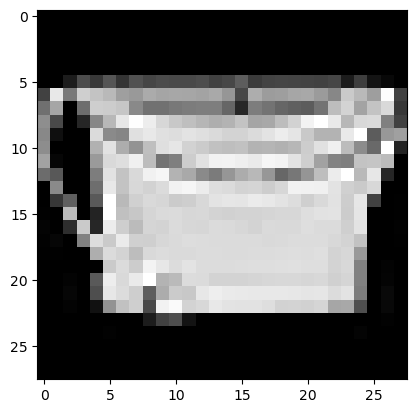

In [52]:
rand_image = get_img_from_cluster(cluster) 
plt.imshow(rand_image.reshape((28,28)),cmap= plt.cm.gray)
plt.show()

In [53]:
img_3dims = np.expand_dims(rand_image, axis = 0)
rand_image.shape
img_4dims = np.expand_dims(img_3dims, axis = -1)
img_4dims.shape

(1, 28, 28, 1)

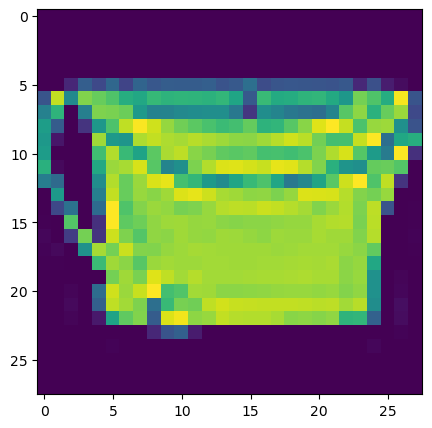

In [57]:
import cv2

# noise_test = np.random.normal(0, 1, (1, 28, 28,1))
# img_4dims_combined = edge_img_4dims + noise_test

# PLot the combined image
plt.figure(figsize=(5,5))
plt.imshow(img_4dims.reshape((28,28)))
plt.show()

In [78]:
# edge_img_4dims = extract_model.predict(img_4dims)
noise = randn(100 * 1)
noise_input = noise.reshape(1, 100)

In [79]:
cluster_dim = list([cluster])

In [80]:
cluster_dim = np.expand_dims(cluster_dim, axis = 0)
print(cluster_dim.shape)

(1, 1)


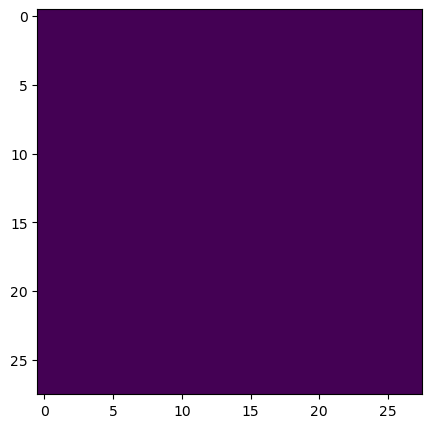

In [81]:
# create new image and from intent input

image_gen = generator.predict_on_batch([noise_input, cluster_dim])
# new_image = generator.predict(edge_img_4dims)

plt.figure(figsize=(5,5))
plt.imshow(image_gen.reshape((28,28)))
plt.show()

The ouput show that the model complete convert it to original image but not generate the new one.

# TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs